In [2]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np


In [3]:
import plotly.express as px

In [4]:
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score

In [6]:
graduses = pd.read_csv('data/Offset equipment temperature degrees Celsius observed every 10 minutes.csv')
df = graduses.sort_index()

In [8]:
df

,Unnamed: 0,temperature
0,1,22.0
1,2,22.8
2,3,22.9
3,4,22.5
4,5,22.5
...,...,...
4320,4321,32.7
4321,4322,32.5
4322,4323,32.5
4323,4324,32.0


## Предсказание временного ряда с помощью деревьев

Попробуем обычное дерево решений и случайный лес, а потом сравним результаты

In [9]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from numpy import asarray

In [10]:
n_vars = 1 if type(df) is list else df.shape[1]
cols = list()
for i in range(1, 0, -1):
    cols.append(df.shift(i))
for i in range(0, 1):
    cols.append(df.shift(-i))
# put it all together
agg = pd.concat(cols, axis=1)
agg.dropna(inplace=True)
list_for_forecast = agg.values

In [11]:
len(list_for_forecast)

4324

In [12]:
def decision_tree_forecast(train, testX):
    train = asarray(train)
    trainX, trainy = train[:, :-1], train[:, -1]
    model = DecisionTreeRegressor(random_state=0)
    model.fit(trainX, trainy)
    yhat = model.predict([testX])
    return yhat[0]

In [19]:
def random_forest_forecast(train, testX):
    train = asarray(train)
    trainX, trainy = train[:, :-1], train[:, -1]
    model = RandomForestRegressor(n_estimators=5)
    model.fit(trainX, trainy)
    yhat = model.predict([testX])
    return yhat[0]

# У меня одно дерево делалось 15 лет (1m 20s) на 4324 элементах...
# А лес на 5 деревьях - (5m 33s)

In [20]:
predictions = list()
size = int(len(list_for_forecast) * 0.66)
train, test = list_for_forecast[0:size], list_for_forecast[size:len(list_for_forecast)]
history = [x for x in train]

for i in range(len(test)):
    testX, testy = test[i, :-1], test[i, -1]
    yhat = random_forest_forecast(history, testX)
    predictions.append(yhat)
    history.append(test[i])

error = mean_absolute_error(test[:, -1], predictions)
print("Random Forest error: ", error)

Random Forest error:  0.4299524133242691


In [22]:
print("Random Forest metrics: ")
print("RMSE:", np.sqrt(mean_squared_error(test[:, -1], predictions)))
print("MAPE:", mean_absolute_percentage_error(test[:, -1], predictions))
print("MAE:", mean_absolute_error(test[:, -1], predictions))
print("R2: ", r2_score(test[:, -1], predictions))

Random Forest metrics: 
RMSE: 0.6109428137607705
MAPE: 0.014788209163315852
MAE: 0.4299524133242691
R2:  0.9861843489274805


Random Forest metrics: on 5 decision  <br>
RMSE: <b>0.6109428137607705</b><br>
MAPE: <b>0.014788209163315852</b><br>
MAE: <b>0.4299524133242691</b><br>
R2:  <b>0.9861843489274805</b><br>
<br>
Decision Forest [tree?] metrics:<br> 
RMSE: <b>0.7646151331457454</b><br>
MAPE: <b>0.01801202880182004</b><br>
MAE: <b>0.5218218898708361</b><br>
R2:  <b>0.9783600619497034</b>

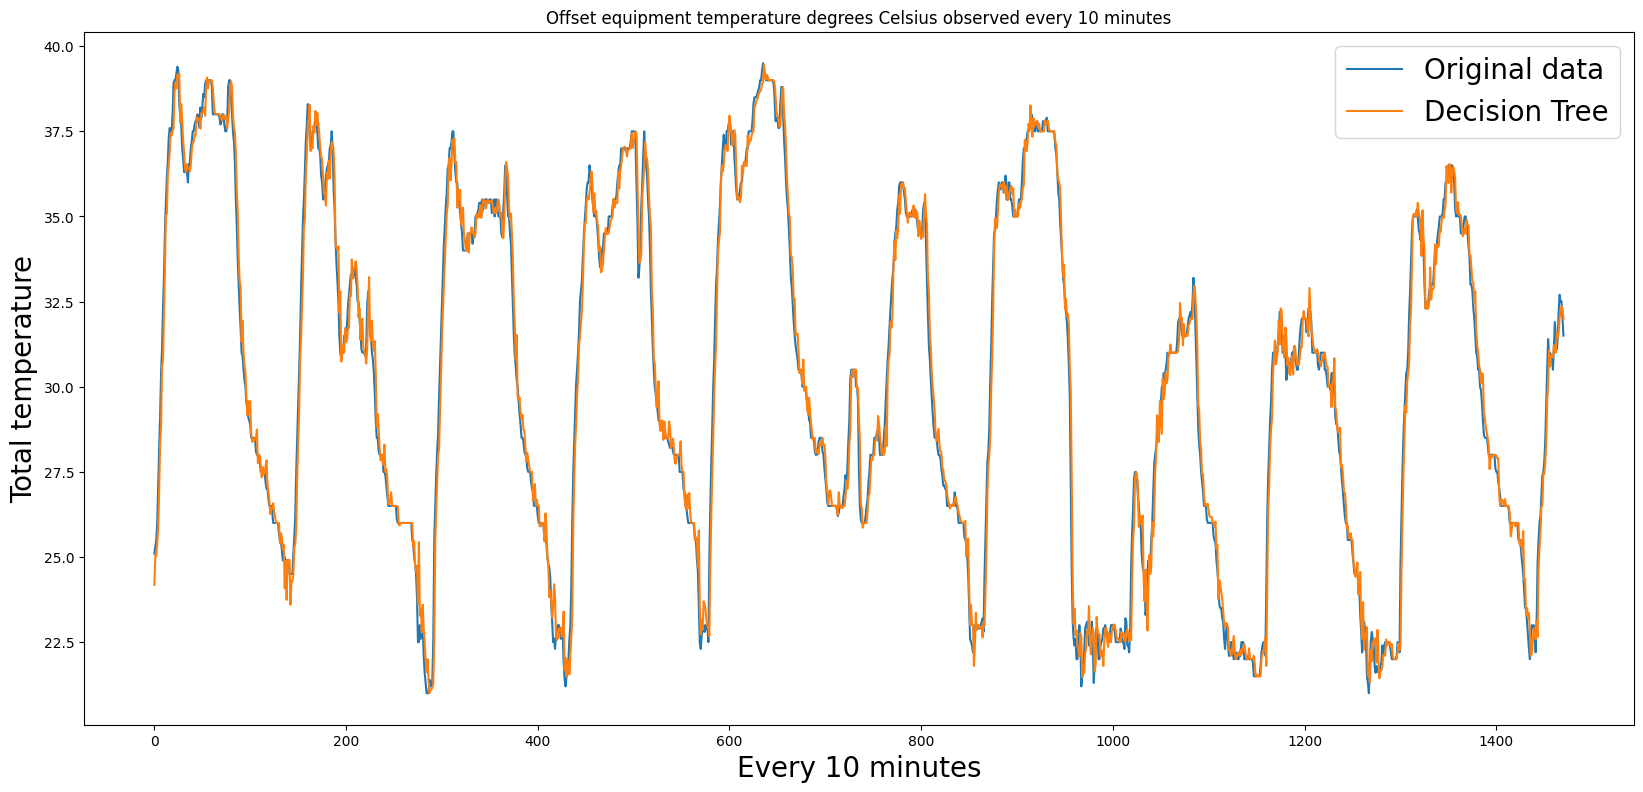

In [23]:
fig = plt.figure(figsize=(20, 9))
plt.plot(test[:, -1], label='Original data')
plt.plot(predictions, label='Decision Tree')
plt.legend(fontsize="20")
plt.title('Offset equipment temperature degrees Celsius observed every 10 minutes')
plt.ylabel('Total temperature', fontsize="20")
plt.xlabel('Every 10 minutes', fontsize="20")
plt.show()

In [16]:
predictions = list()
size = int(len(list_for_forecast) * 0.66)
train, test = list_for_forecast[0:size], list_for_forecast[size:len(list_for_forecast)]
history = [x for x in train]

for i in range(len(test)):
    testX, testy = test[i, :-1], test[i, -1]
    yhat = decision_tree_forecast(history, testX)
    predictions.append(yhat)
    history.append(test[i])


In [17]:
print("Decision Forest metrics: ")
print("RMSE:", np.sqrt(mean_squared_error(test[:, -1], predictions)))
print("MAPE:", mean_absolute_percentage_error(test[:, -1], predictions))
print("MAE:", mean_absolute_error(test[:, -1], predictions))
print("R2: ", r2_score(test[:, -1], predictions))

Decision Forest metrics: 
RMSE: 0.7646151331457454
MAPE: 0.01801202880182004
MAE: 0.5218218898708361
R2:  0.9783600619497034


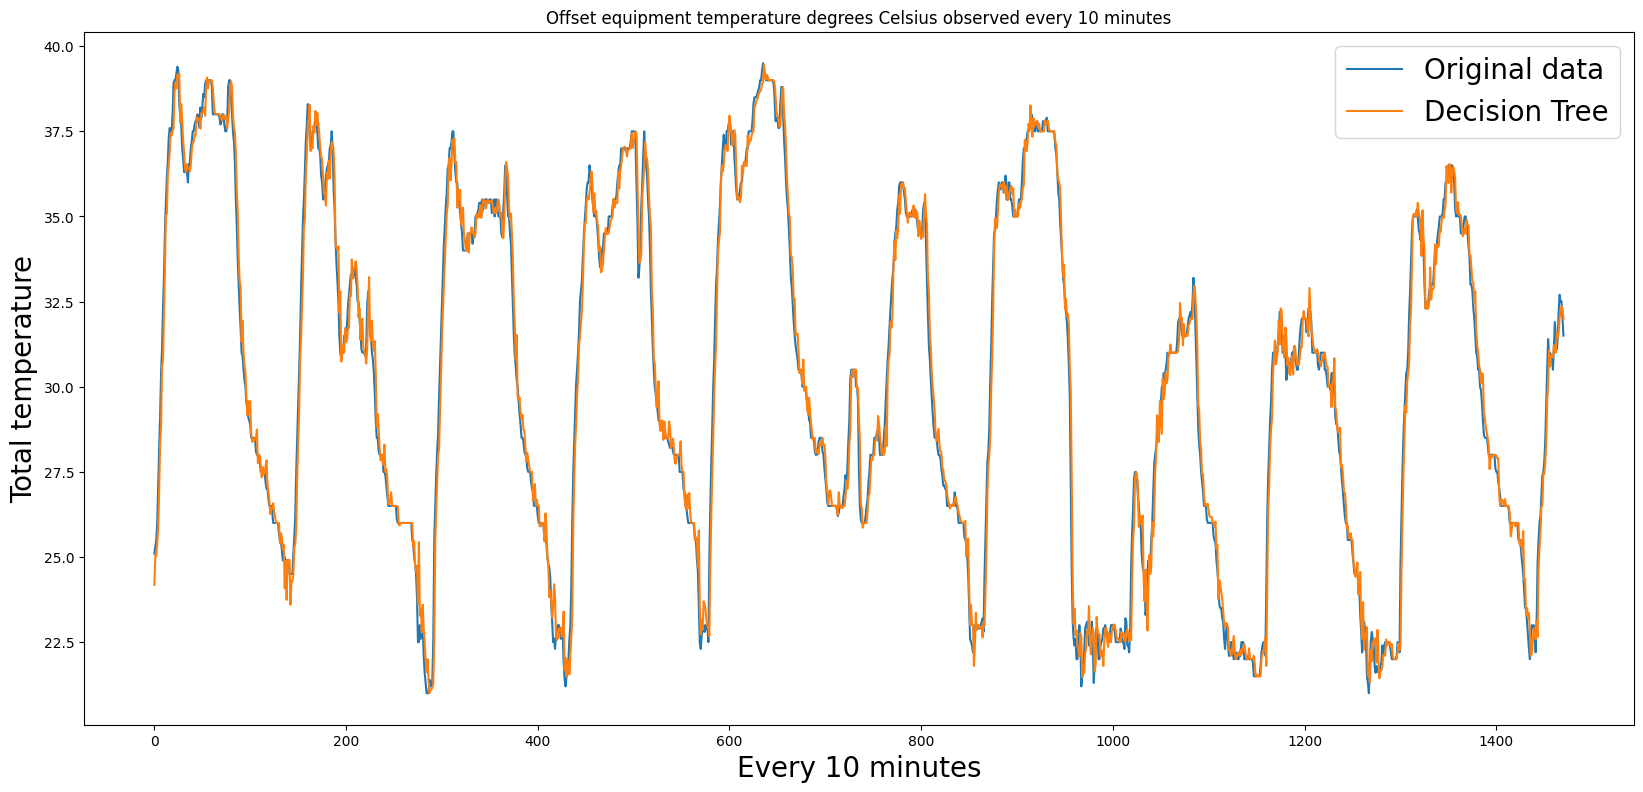

In [21]:
fig = plt.figure(figsize=(20, 9))
plt.plot(test[:, -1], label='Original data')
plt.plot(predictions, label='Decision Tree')
plt.legend(fontsize="20")
plt.title('Offset equipment temperature degrees Celsius observed every 10 minutes')
plt.ylabel('Total temperature', fontsize="20")
plt.xlabel('Every 10 minutes', fontsize="20")
plt.show()

## Детекция аномалий с помощью isolated forest

In [9]:
from sklearn.ensemble import IsolationForest

In [10]:
# аналогичным образом загружаем данные о пассажирах
graduses = pd.read_csv('data/Offset equipment temperature degrees Celsius observed every 10 minutes.csv')
# также устанавливаем индекс и сортируем
df = graduses.sort_index()

df

,Unnamed: 0,temperature
0,1,22.0
1,2,22.8
2,3,22.9
3,4,22.5
4,5,22.5
...,...,...
4320,4321,32.7
4321,4322,32.5
4322,4323,32.5
4323,4324,32.0


In [11]:
model = IsolationForest(contamination=0.004)
model.fit(df[['temperature']])

IsolationForest(contamination=0.004)

In [12]:
df['outliers'] = pd.Series(model.predict(df[['temperature']])).apply(lambda x: 'yes' if (x == -1) else 'no' )

In [13]:
df.query('outliers=="yes"')

,Unnamed: 0,temperature,outliers
678,679,19.4,yes
679,680,19.0,yes
680,681,19.1,yes
681,682,19.4,yes
682,683,19.2,yes
683,684,19.1,yes


In [14]:
fig = px.scatter(df, x='Unnamed: 0', y='temperature', color='outliers')
fig.update_xaxes(
    rangeslider_visible=True,
)
fig.show()